In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx
import pathlib

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

/home/sgupta/anaconda3/envs/pytenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
op_path = './data/graph_data/1_hr_time_window_static_graph/'
pathlib.Path(op_path).mkdir(parents=True, exist_ok=True) 

In [3]:
route_ids = [3,4,5,6,7,8,9,14,17,18,19,22,23,28,29,34,41,42,50,52,55,56]

In [4]:
all_df = []
for route_id in route_ids:
    inp_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/route_specific_w_census_dist_delay_weather_traffic/{route_id}'
    filename = f'stoplevel_route_{route_id}_w_census_dist_delay_weather_traffic.parquet'
    df = pd.read_parquet(f'{inp_fp}/{filename}')
    
    all_df.append(df)

all_df = pd.concat(all_df)

In [5]:
# TODO: on all data. 
# Converting 'precipitation_intensity','temperature','humidity' scaling them between 0 and 1 for the model to understand these values 
num_columns = ['precipitation_intensity','temperature','humidity','actual_hdwy', 'delay','displacement','median_income_last12months','average_speed']
    

ss = MinMaxScaler()
ss.fit(all_df[num_columns])

MinMaxScaler()

In [6]:
del all_df

import gc
gc.collect()

32

In [7]:
graphs = []
node_feature_matrix_graphs = []
y_class_graphs = []

for route_id in tqdm(route_ids):
    inp_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/route_specific_w_census_dist_delay_weather_traffic/{route_id}'
    filename = f'stoplevel_route_{route_id}_w_census_dist_delay_weather_traffic.parquet'
    df = pd.read_parquet(f'{inp_fp}/{filename}')

    df = df.drop_duplicates(subset=['transit_date', 'trip_id', 'route_direction_name', 'block_abbr', 'pattern_num','stop_sequence'])
    df['delay'] = df['delay'].fillna(0)
    df['actual_hdwy'] = df['actual_hdwy'].fillna(0)

    # Converting route_direction_name, is_weekend and is_holiday to OHE - they have only 2 values hence just mapping them to 0 and 1.
    # Create a direction mapping dictionary
    direction_mapping = {'TO DOWNTOWN': 1, 'FROM DOWNTOWN': 0}
    # Apply the mapping to the 'direction' column
    df['route_direction_name'] = df['route_direction_name'].map(direction_mapping)

    # Create a true false mapping dictionary
    true_false_mapping = {True: 1, False: 0}
    # Apply the mapping to the holiday and weekend columns
    df['is_holiday'] = df['is_holiday'].map(true_false_mapping)
    df['is_weekend'] = df['is_weekend'].map(true_false_mapping)

    # Normalising some of the columns as they are percentage values: 'white_pct', 'black_pct', 'hispanic_pct', 'public_transit_pct'
    df['white_pct'] = df['white_pct']/100
    df['black_pct'] = df['black_pct']/100
    df['hispanic_pct'] = df['hispanic_pct']/100
    df['public_transit_pct'] = df['public_transit_pct']/100

    ## No Normalising required for 'pct_public_transit_for_work', 'extreme_congestion' as it is between 0 and 1 already
    df[num_columns] = ss.transform(df[num_columns])

    # Getting the source information
    df['source'] = df['stop_id']

    df.sort_values(by=['transit_date', 'trip_id', 'route_direction_name', 'block_abbr', 'pattern_num','stop_sequence'],inplace=True,ignore_index=True)

    # Creating the target column for all the trips in our dataset
    req_df = []
    for (transit_date, trip_id, route_direction_name, block_abbr, pattern_num), tdf in tqdm(df.groupby(['transit_date', 'trip_id','route_direction_name', 'block_abbr', 'pattern_num'])):   
        tdf.sort_values(by=['transit_date', 'trip_id', 'route_direction_name', 'block_abbr', 'pattern_num','stop_sequence'],inplace=True,ignore_index=True)
        if tdf.vehicle_capacity.isna().any():
            continue


        tdf['target'] = tdf['source'].shift(-1).astype(int, errors = 'ignore')
        # tdf = tdf.dropna(subset=['target'])
        tdf['target'] = tdf['target'].fillna('DELETE_NODE')

        temp = []
        for (time_window), time_window_df in tdf.groupby(['time_window']):
            if time_window_df['target'].iloc[-1] != 'DELETE_NODE':
                time_window_df['target'].iloc[-1] = 'DELETE_NODE'

            temp.append(time_window_df)

        req_df.append(pd.concat(temp))

    df = pd.concat(req_df)
    del req_df

    df.sort_values(by=['transit_date', 'route_direction_name' ,'time_window'],ignore_index=True,inplace=True)

    # changing the target of the last row for each 'transit_date', 'route_direction_name' ,'time_window' because this row will be present in the graph for the next day. 
    fixed_df = []
    for (transit_date, route_direction_name, time_window), tdf in tqdm(df.groupby(['transit_date', 'route_direction_name' ,'time_window'])):   
        if tdf['target'].iloc[-1] != 'DELETE_NODE':
            tdf['target'].iloc[-1] = 'DELETE_NODE'

        fixed_df.append(tdf)

    df = pd.concat(fixed_df)
    op_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/graph_specific_data/{route_id}'
    pathlib.Path(op_fp).mkdir(parents=True, exist_ok=True) 

    filename = f'graph_ready_data_{route_id}.parquet'
    df.to_parquet(f'{op_fp}/{filename}')

100%|██████████| 22/22 [18:19<00:00, 49.99s/it] 


In [8]:
# Fixing route 23 data - 
inp_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/graph_specific_data/{23}'
filename = f'graph_ready_data_{23}.parquet'
fix_23_df = pd.read_parquet(f'{inp_fp}/{filename}')

route_23_df = []
for (transit_date, trip_id, route_direction_name, block_abbr, pattern_num), tdf in tqdm(df.groupby(['transit_date', 'trip_id','route_direction_name', 'block_abbr', 'pattern_num'])):
    if (tdf.source == tdf.target).any():
        continue

    route_23_df.append(tdf)

route_23_df = pd.concat(route_23_df)

op_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/graph_specific_data/{23}'
filename = f'graph_ready_data_{23}.parquet'
route_23_df.to_parquet(f'{op_fp}/{filename}')

100%|██████████| 24891/24891 [00:07<00:00, 3270.21it/s]


In [9]:
apc_data = []
for route_id in route_ids:
    inp_fp = f'../../DATASETS/WeGo_Bus_data/STOPLEVEL_PROCESSED/graph_specific_data/{route_id}'
    filename = f'graph_ready_data_{route_id}_1_hr_time_window.parquet'


    df = pd.read_parquet(f'{inp_fp}/{filename}')

    apc_data.append(df)

apc_data = pd.concat(apc_data)

In [11]:
apc_data.sort_values(by=['transit_date','route_direction_name','departure_time'],inplace=True,ignore_index=True)


from sklearn.preprocessing import LabelEncoder
# ,'time_window_1_hr'
categorical_columns = ['dayofweek','month','year','time_window_1_hr']
for col in categorical_columns:
    le = LabelEncoder()
    le = le.fit(apc_data[col].unique())

    apc_data[f'{col}_cat'] = le.transform(apc_data[col])

### First Creating one graph for all routes version 

In [12]:
node_list = apc_data[apc_data['route_direction_name'] == 0].source.unique()

In [14]:
apc_data.sort_values(by=['transit_date','route_direction_name','departure_time'],inplace=True,ignore_index=True)

In [15]:
# Create an empty graph
G = nx.DiGraph()

# Add nodes to the graph from the list
G.add_nodes_from(node_list)

In [16]:
from copy import deepcopy

graphs = []
count = 0
pos_df_list = []
# for (route_direction_name), tdf in tqdm(df.groupby(['route_direction_name' ])):   
for (transit_date, route_direction_name, time_window), tdf in tqdm(apc_data.groupby(['transit_date', 'route_direction_name' , 'time_window_1_hr'])):   
    if route_direction_name == 1:
        continue

    new_G = deepcopy(G)

    # Add edges from the DataFrame to the graph
    for index, row in tdf.iterrows():
        source = row['source']
        target = row['target']
        displacement = row['displacement']
        median_income_last12months = row['median_income_last12months']
        white_pct = row['white_pct']
        black_pct = row['black_pct']
        hispanic_pct = row['black_pct']
        public_transit_pct = row['black_pct']
        pct_public_transit_for_work = row['black_pct']
        new_G.add_edge(source, target, displacement=displacement, median_income_last12months=median_income_last12months,
                                        white_pct=white_pct, black_pct=black_pct, hispanic_pct=hispanic_pct, 
                                        public_transit_pct=public_transit_pct, pct_public_transit_for_work=pct_public_transit_for_work)
    try:
        new_G.remove_node('DELETE_NODE')
    except:
        print('iteration:',count)

    graphs.append(new_G)
    
    pos_df = tdf.groupby(['stop_id']).agg({
                                            'map_longitude':'first','map_latitude':'first'
                                            })
    
    pos_df_list.append(pos_df)

100%|██████████| 26373/26373 [03:39<00:00, 120.23it/s]


In [19]:
pos_df = apc_data[apc_data['route_direction_name'] == 0].groupby(['stop_id']).agg({
                                            'map_longitude':'first','map_latitude':'first'
                                            })

In [47]:
import plotly.express as px
import pandas as pd


def plot_and_save_graph_with_mapbox(G,pos_df,transit_date,time_window):
    pos = pos_df.to_dict(orient='index')
    pos = {key: tuple(value.values()) for key, value in pos.items()}

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        # edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        # edge_y.append(None)

    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    # Create a DataFrame or provide edge_x, edge_y, node_x, node_y
    # with the appropriate data for your plot.

    # Create the edge DataFrame (You can replace this with your actual data)
    edge_df = pd.DataFrame({'x': edge_x, 'y': edge_y})

    # Create the node DataFrame (You can replace this with your actual data)
    node_df = pd.DataFrame({'x': node_x, 'y': node_y, 'text': node_text})

    # Create the map
    fig = px.scatter_mapbox(node_df, lat="y", lon="x", hover_data="text",
                            color_discrete_sequence=["blue"], zoom=10,
                            center={"lat": 36.1627, "lon": -86.7816}, title="Network graph with Mapbox in Python")

    # Add the edges as lines (You can replace this with your actual data)
    for i in range(0, len(edge_df), 2):
        start_node = edge_df.iloc[i]
        end_node = edge_df.iloc[i + 1]
        line = pd.DataFrame({'x': [start_node['x'], end_node['x']], 'y': [start_node['y'], end_node['y']]})
        fig.add_trace(px.line_mapbox(line, lat="y", lon="x").data[0])

    # Customize the map layout
    fig.update_layout(mapbox_style="light",
                    mapbox_accesstoken="pk.eyJ1IjoiZ3VwdGFzYW16IiwiYSI6ImNsZ3d6Zzh0eTAwbjMzcW8wcnJybmp6cmcifQ.4ZGZIjNSFzk6aYjYUT3P1Q",  # Replace with your Mapbox access token
                    mapbox_center={"lat": 36.1627, "lon": -86.7816},
                    showlegend=False,
                    hovermode='closest',
                    margin={"b": 20, "l": 5, "r": 5, "t": 40},
                    annotations=[
                        dict(text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'>https://plotly.com/ipython-notebooks/network-graphs/</a>",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)
                    ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    op_fp = './plots/single_graph_for_each_time_window/graph_strucutre/with_mapbox'
    pathlib.Path(op_fp).mkdir(parents=True, exist_ok=True) 
    

    # Save or display the figure
    fig.write_html(f'{op_fp}/graph_with_mapbox.html')

In [48]:
plot_and_save_graph_with_mapbox(graphs[15],pos_df,'transit_date','time_window')

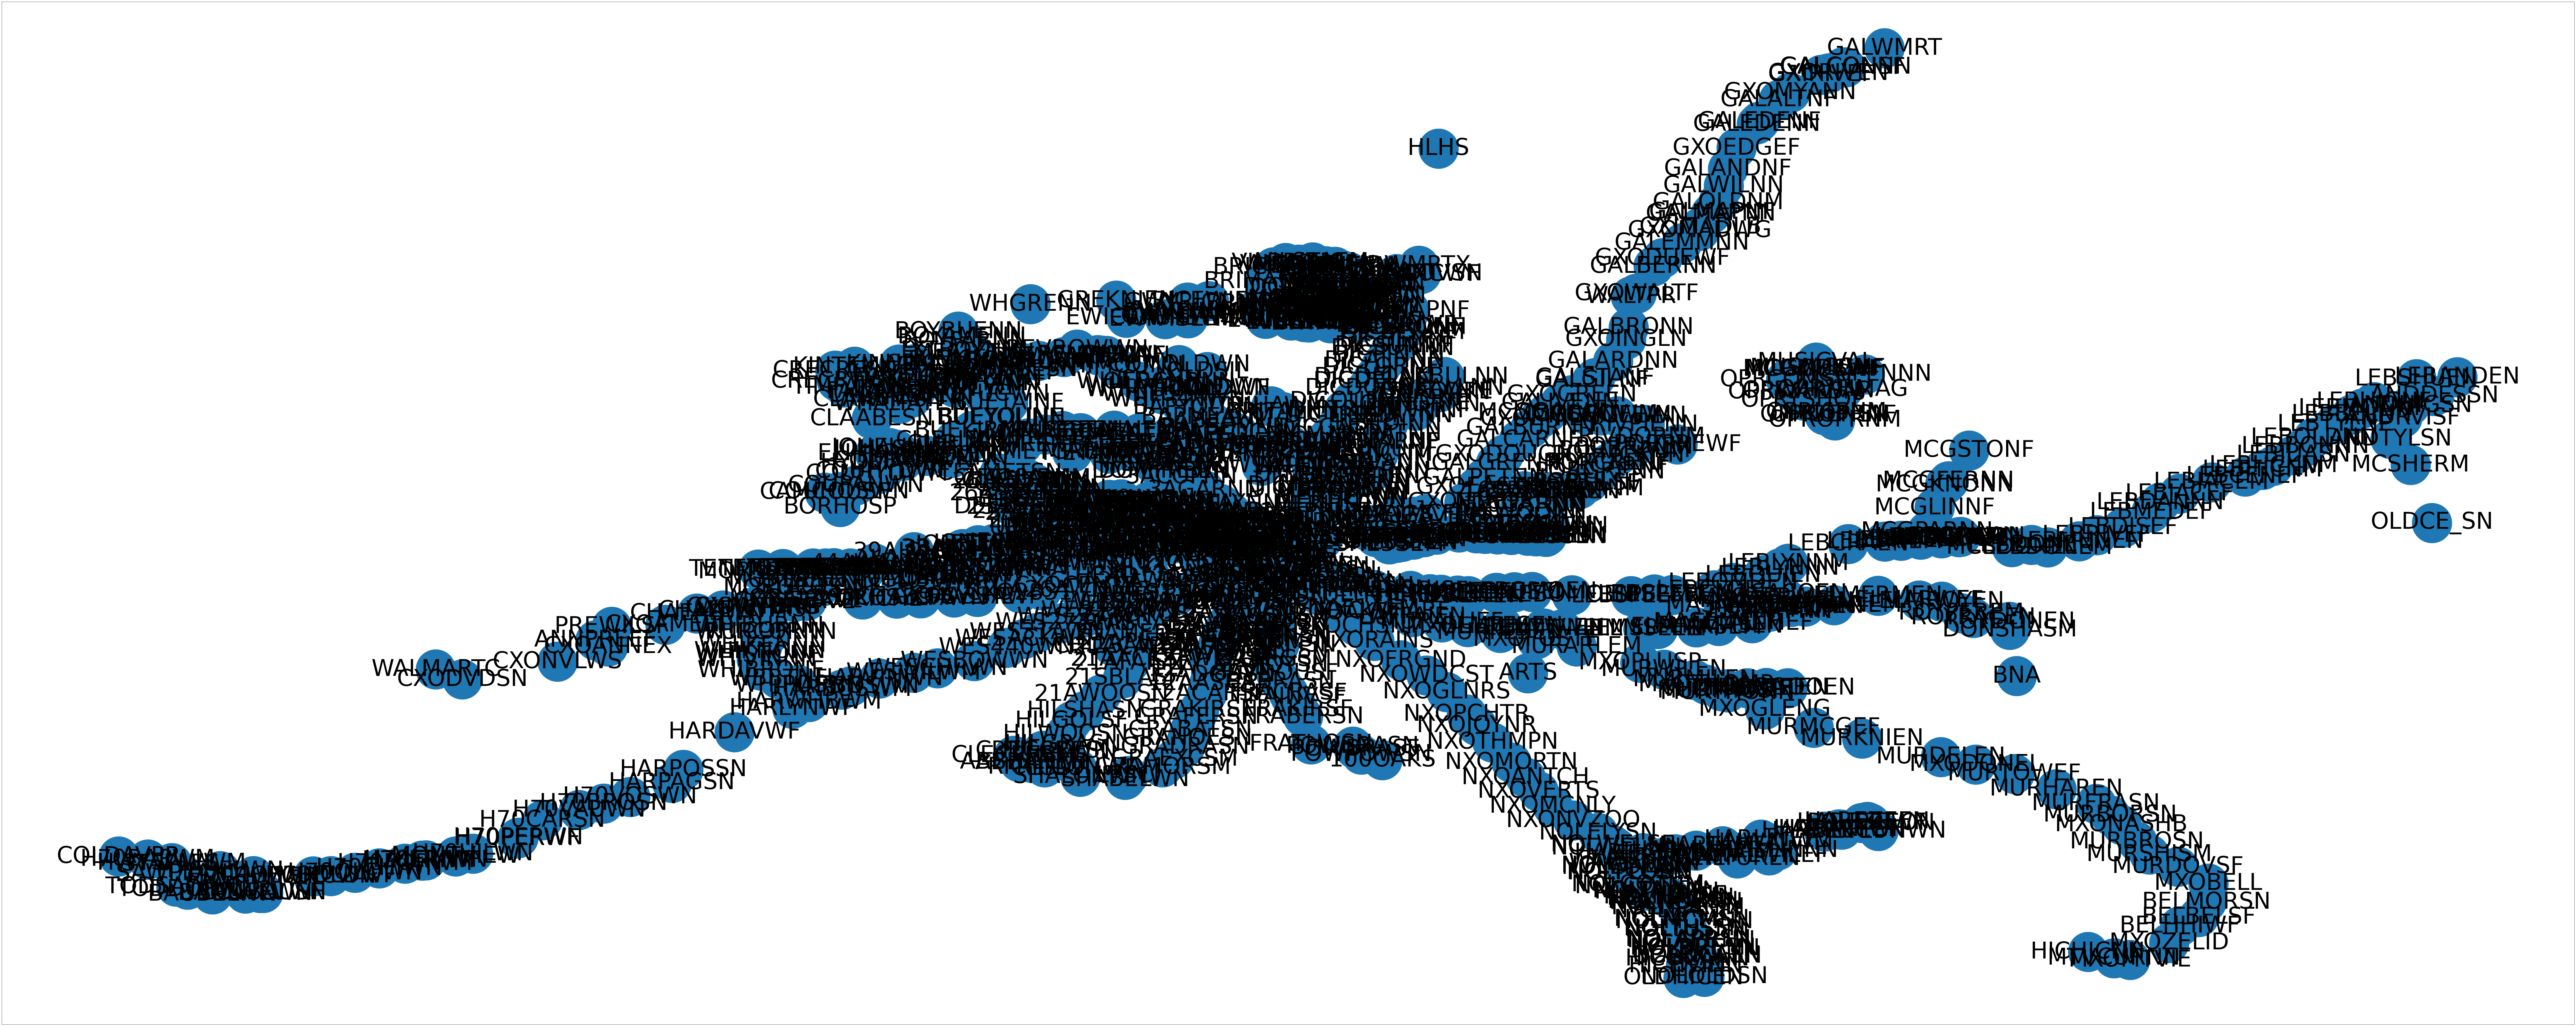

In [22]:
# pos = nx.spiral_layout(G)
pos = pos_df.to_dict(orient='index')
pos = {key: tuple(value.values()) for key, value in pos.items()}

fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(graphs[15],font_size=100,node_size=30000, arrowsize=300, width=10,pos=pos)


In [23]:
len(graphs)

13567

In [24]:
# Plotting on a map
pos = pos_df.to_dict(orient='index')
pos = {key: tuple(value.values()) for key, value in pos.items()}

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    # edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    # edge_y.append(None)

node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

import plotly.express as px
import pandas as pd

# Create a DataFrame or provide edge_x, edge_y, node_x, node_y
# with the appropriate data for your plot.

# Create the edge DataFrame (You can replace this with your actual data)
edge_df = pd.DataFrame({'x': edge_x, 'y': edge_y})

# Create the node DataFrame (You can replace this with your actual data)
node_df = pd.DataFrame({'x': node_x, 'y': node_y, 'text': node_text})

# Create the map
fig = px.scatter_mapbox(node_df, lat="y", lon="x", hover_data="text",
                        color_discrete_sequence=["blue"], zoom=10,
                        center={"lat": 36.1627, "lon": -86.7816}, title="Network graph with Mapbox in Python")

# Add the edges as lines (You can replace this with your actual data)
for i in range(0, len(edge_df), 2):
    start_node = edge_df.iloc[i]
    end_node = edge_df.iloc[i + 1]
    line = pd.DataFrame({'x': [start_node['x'], end_node['x']], 'y': [start_node['y'], end_node['y']]})
    fig.add_trace(px.line_mapbox(line, lat="y", lon="x").data[0])

# Customize the map layout
fig.update_layout(mapbox_style="light",
                  mapbox_accesstoken="pk.eyJ1IjoiZ3VwdGFzYW16IiwiYSI6ImNsZ3d6Zzh0eTAwbjMzcW8wcnJybmp6cmcifQ.4ZGZIjNSFzk6aYjYUT3P1Q",  # Replace with your Mapbox access token
                  mapbox_center={"lat": 36.1627, "lon": -86.7816},
                  showlegend=False,
                  hovermode='closest',
                  margin={"b": 20, "l": 5, "r": 5, "t": 40},
                  annotations=[
                      dict(text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'>https://plotly.com/ipython-notebooks/network-graphs/</a>",
                           showarrow=False,
                           xref="paper", yref="paper",
                           x=0.005, y=-0.002)
                  ],
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

# Save or display the figure
fig.write_html('./graph_all_routes_with_mapbox.html')
fig.write_image("./fig1.pdf")
# fig.show()

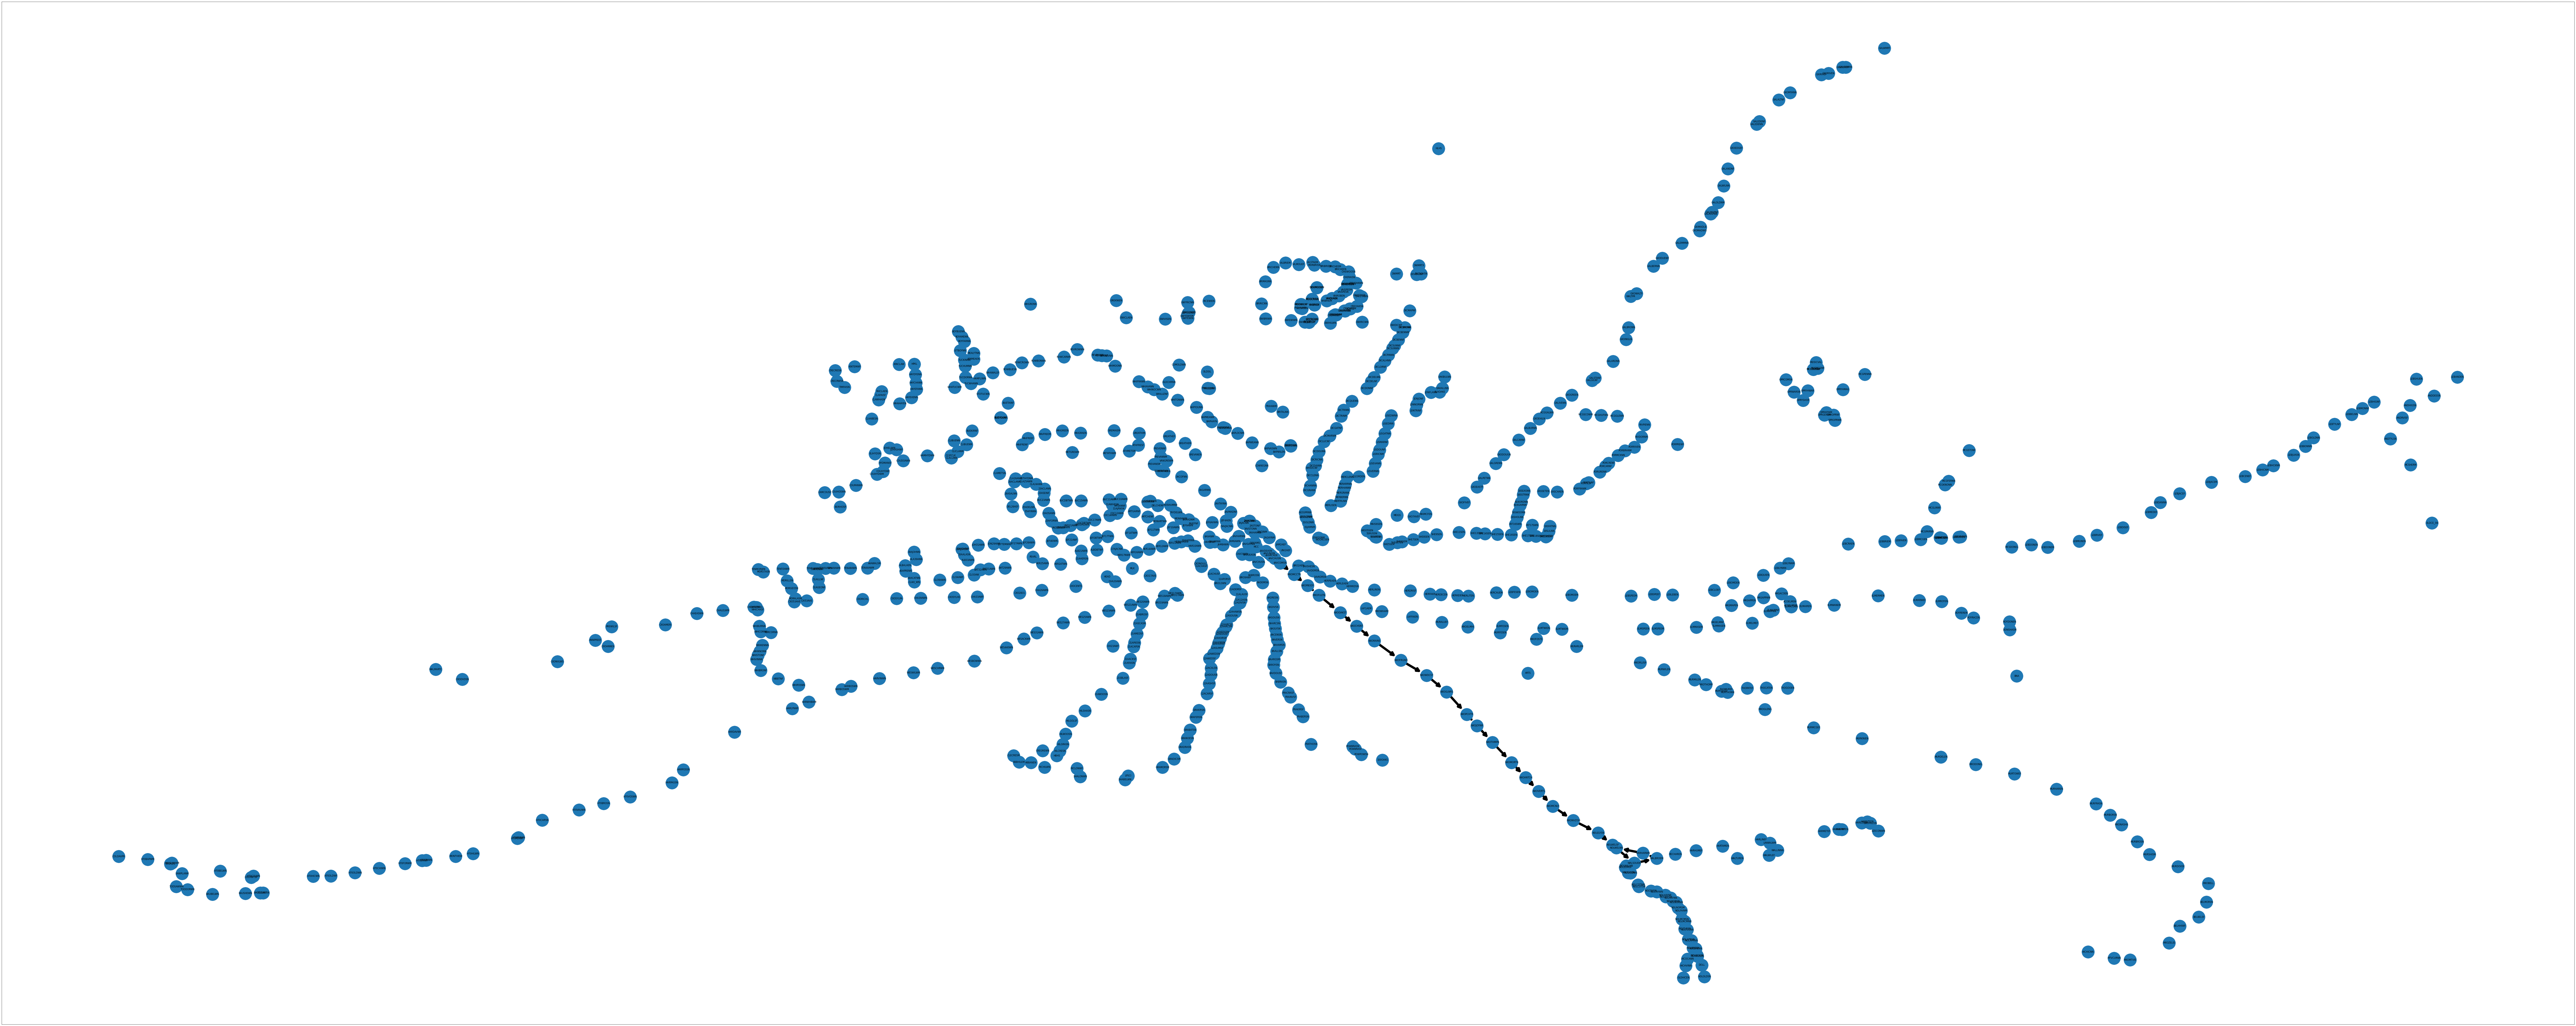

In [45]:
# pos = nx.spiral_layout(graphs[0])
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(graphs[15],font_size=10,node_size=3000, arrowsize=30, width=10,pos=pos)

In [26]:
print(new_G.number_of_nodes())
print(new_G.number_of_edges())

836
51


### Creating the feature node matrix for the first graph

In [27]:
# Getting the load bins
def bin_load(load, capacity):
    percentages = [0., .33, .66, 1.0]
    # percentages = [0., .10, .25, 1.0]

    transit_cap = [round(p * capacity) for p in percentages]
    labels = [0, 1, 2]
    
    bin_label = pd.cut(x=[load], bins=transit_cap, labels=labels, include_lowest=True)[0]
    
    if pd.isnull(bin_label):
        return 3

    return bin_label

In [28]:
features = ['route_direction_name','pattern_num','is_weekend','month','year','is_holiday','vehicle_capacity','precipitation_intensity','temperature','humidity','time_window'] 
features = ['precipitation_intensity','temperature','humidity','delay','average_speed','extreme_congestion',
            'dayofweek','month','year','time_window_1_hr'] 

node_feature_matrix_graphs = []
y_class_graphs = []

iteration = 0
for (transit_date, route_direction_name, time_window), tdf in tqdm(apc_data.groupby(['transit_date', 'route_direction_name' ,'time_window_1_hr'])):   
    # Create node feature matrix and the y_class matrix (Creating this as well as a dictionary for now)
    # Designed as a dictionary. Traverse each row sequentially and get the aggregate (mean) of all the values 
    node_feature_matrix = {}
    y_class = {}

    if route_direction_name == 1:
        continue

    # Setting the keys to maintain the sequential order with respect to nodes in graph
    for key in list(graphs[iteration].nodes):
        node_feature_matrix[key] = None
        y_class[key] = None

    for (stop_id), stop_df in tdf.groupby(['stop_id']):
        stop_id = stop_df['stop_id'].iloc[0]
        node_feature_matrix[stop_id] = {}

        # Aggregate (mean) the Weather data - temp, precipitation, humidity. 
        node_feature_matrix[stop_id]['precipitation_intensity'] = stop_df.precipitation_intensity.mean()
        node_feature_matrix[stop_id]['temperature'] = stop_df.temperature.mean()
        node_feature_matrix[stop_id]['humidity'] = stop_df.humidity.mean()

        # node_feature_matrix[stop_id]['actual_hdwy'] = stop_df.actual_hdwy.mean()
        node_feature_matrix[stop_id]['delay'] = stop_df.delay.mean()

        # Aggregate Traffic data after merging.
        node_feature_matrix[stop_id]['average_speed'] = stop_df.average_speed.mean()
        node_feature_matrix[stop_id]['extreme_congestion'] = stop_df.extreme_congestion.mean()

        # Encoding time embeddings as OHE
        node_feature_matrix[stop_id]['dayofweek'] = stop_df.dayofweek_cat.iloc[0]
        node_feature_matrix[stop_id]['month'] = stop_df.month_cat.iloc[0]
        node_feature_matrix[stop_id]['year'] = stop_df.year_cat.iloc[0]
        node_feature_matrix[stop_id]['time_window_1_hr'] = stop_df.time_window_1_hr_cat.iloc[0]

        # Getting the binned load using mean load and mean vehicle capacity
        mean_load = stop_df.load.max()
        mean_vehicle_capacity = stop_df.vehicle_capacity.max()
        binned_load = bin_load(mean_load,mean_vehicle_capacity)

        # Getting the mean of the load - will bin it later using vehicle capacity
        y_class[stop_id] = binned_load


    node_feature_matrix_graphs.append(node_feature_matrix)
    y_class_graphs.append(y_class)
    iteration = iteration+1

100%|██████████| 26373/26373 [32:32<00:00, 13.51it/s] 


In [29]:
import pickle
with open("./data/graph_data/1_hr_time_window_static_graph/node_feature_matrix_single_graph.pkl", 'wb') as fp:
    pickle.dump(node_feature_matrix_graphs, fp)

with open("./data/graph_data/1_hr_time_window_static_graph/y_class_single_graph.pkl", 'wb') as fp:
    pickle.dump(y_class_graphs, fp)

with open("./data/graph_data/1_hr_time_window_static_graph/graph_single_graph.pkl", 'wb') as fp:
    pickle.dump(graphs, fp)

In [30]:
# Code to load data because the previous code takes a long time to execute

# import pickle
# with open("./data/graph_data/1_hr_time_window_static_graph/node_feature_matrix_single_graph.pkl", 'rb') as fp:
#     temp = pickle.load(fp)

# with open("./data/graph_data/1_hr_time_window_static_graph/y_class_single_graph.pkl", 'rb') as fp:
#     y_class_graphs = pickle.load(fp)

# with open("./data/graph_data/1_hr_time_window_static_graph/graph_single_graph.pkl", 'rb') as fp:
#     graphs = pickle.load(fp)

In [31]:
# Below value should equal (number of nodes, number of features)
print("Feature Matrix shape:",np.array(node_feature_matrix_graphs).shape)
print("Number of nodes:",len(G.nodes))
print('Number of Features: ',len(features))

Feature Matrix shape: (13567,)
Number of nodes: 836
Number of Features:  10


In [32]:
# Creating the py geometric graph from networkx graph
pyg_graph = from_networkx(graphs[0],group_edge_attrs=['displacement','median_income_last12months',
                                                                        'white_pct', 'black_pct', 'hispanic_pct', 
                                                                        'public_transit_pct', 'pct_public_transit_for_work'])

In [33]:
for iteration in tqdm(range(len(node_feature_matrix_graphs))):
    # Converting y_class to list from dictionary
    y_class_graphs[iteration] = list(y_class_graphs[iteration].values())

    # Converting node_feature_matrix to 2D matrix from dictionary of dictionaries
    for key in node_feature_matrix_graphs[iteration]:
        try:
            node_feature_matrix_graphs[iteration][key] = list(node_feature_matrix_graphs[iteration][key].values())
        except:
            pass
    node_feature_matrix_graphs[iteration] = list(node_feature_matrix_graphs[iteration].values())

100%|██████████| 13567/13567 [00:04<00:00, 3118.57it/s]


In [35]:
# Print some stats
print("Number of graphs: ",len(graphs))
print("Number of node_feature_matrix_graphs: ",len(node_feature_matrix_graphs))
print("Number of y_class_graphs: ",len(y_class_graphs))


Number of graphs:  13567
Number of node_feature_matrix_graphs:  13567
Number of y_class_graphs:  13567


In [36]:
node_feature_matrix_graphs_2 = []
graphs_2 = []
y_class_graphs_2 = []

In [38]:
# Imputing values for None rows 

for i in range(len(node_feature_matrix_graphs)):
    for j in range(len(node_feature_matrix_graphs[i])):
        # print(node_feature_matrix_graphs[i][j])
        if(node_feature_matrix_graphs[i][j] is None):
            node_feature_matrix_graphs[i][j] = np.ones(len(features))
        else:
            node_feature_matrix_graphs[i][j] = np.array(node_feature_matrix_graphs[i][j])


for i in range(len(y_class_graphs)):
    # print(y_class)
    for j in range(len(y_class_graphs[i])):
        if(y_class_graphs[i][j] is None):
            y_class_graphs[i][j] = 4

In [39]:
y_dict = {
    '0':0,
    '1':0,
    '2':0,
    '3':0,
    '4':0,
    'None':0
}

for i in range(len(y_class_graphs)):
    # print(y_class)
    for j in range(len(y_class_graphs[i])):
        y_dict[str(y_class_graphs[i][j])] += 1

print(y_dict)

{'0': 1249006, '1': 698934, '2': 98306, '3': 27857, '4': 9267909, 'None': 0}

In [42]:
# Creating the resulting dataframe with all the pygeometric graph data
dataset_all_routes = []

count = 0
for iteration in tqdm(range(len(graphs))):

    try:
        # Creating the py geometric graph from networkx graph
        pyg_graph = from_networkx(graphs[iteration],group_edge_attrs=['displacement','median_income_last12months',
                                                                        'white_pct', 'black_pct', 'hispanic_pct', 
                                                                        'public_transit_pct', 'pct_public_transit_for_work'])
        # Setting the node feature matrix for the py geometric graph 
        pyg_graph.x = torch.tensor(node_feature_matrix_graphs[iteration]).float()
        # Setting the y_class for the py geometric graph 
        pyg_graph.y = torch.tensor(y_class_graphs[iteration]).long()

        dataset_all_routes.append(pyg_graph)
    except Exception as e:
        print(e)
        count = count + 1
        continue
        # print("Some issue with graph: ",iteration)

print("These graphs were removed because there was only a single node in these graphs:",count)

  1%|          | 101/13567 [00:00<01:17, 173.01it/s]

'displacement'
'displacement'
'displacement'


  3%|▎         | 394/13567 [00:01<00:41, 314.65it/s]

'displacement'


  4%|▍         | 592/13567 [00:02<00:39, 325.15it/s]

'displacement'


  6%|▋         | 858/13567 [00:03<00:38, 328.15it/s]

'displacement'


  7%|▋         | 924/13567 [00:03<00:39, 322.37it/s]

'displacement'
'displacement'


  9%|▊         | 1156/13567 [00:04<00:39, 318.03it/s]

'displacement'


  9%|▉         | 1224/13567 [00:04<00:37, 326.68it/s]

'displacement'
'displacement'


 10%|█         | 1423/13567 [00:05<00:38, 317.41it/s]

'displacement'


 14%|█▍        | 1881/13567 [00:06<00:37, 312.87it/s]

'displacement'
'displacement'


 15%|█▍        | 2013/13567 [00:07<00:36, 314.66it/s]

'displacement'


 15%|█▌        | 2077/13567 [00:07<00:36, 316.94it/s]

'displacement'
'displacement'


 20%|█▉        | 2655/13567 [00:09<00:35, 310.46it/s]

'displacement'


 20%|██        | 2719/13567 [00:09<00:34, 310.35it/s]

'displacement'
'displacement'


 23%|██▎       | 3099/13567 [00:10<00:34, 305.52it/s]

'displacement'
'displacement'
'displacement'


 24%|██▍       | 3290/13567 [00:11<00:33, 303.68it/s]

'displacement'


 26%|██▌       | 3539/13567 [00:12<00:32, 307.04it/s]

'displacement'


 28%|██▊       | 3858/13567 [00:13<00:31, 309.97it/s]

'displacement'


 30%|██▉       | 4052/13567 [00:13<00:29, 317.44it/s]

'displacement'


 34%|███▍      | 4637/13567 [00:15<00:30, 294.01it/s]

'displacement'


 38%|███▊      | 5218/13567 [00:17<00:25, 323.17it/s]

'displacement'


 51%|█████     | 6855/13567 [00:22<00:22, 303.20it/s]

'displacement'


 58%|█████▊    | 7860/13567 [00:26<00:18, 301.18it/s]

'displacement'


 58%|█████▊    | 7922/13567 [00:26<00:18, 302.99it/s]

'displacement'


 68%|██████▊   | 9278/13567 [00:31<00:14, 294.13it/s]

'displacement'


 70%|███████   | 9551/13567 [00:31<00:13, 290.62it/s]

'displacement'


 72%|███████▏  | 9820/13567 [00:32<00:13, 284.19it/s]

'displacement'
'displacement'


 74%|███████▎  | 10000/13567 [00:33<00:12, 287.21it/s]

'displacement'


 76%|███████▋  | 10363/13567 [00:34<00:11, 273.95it/s]

'displacement'


 81%|████████  | 10924/13567 [00:36<00:09, 290.74it/s]

'displacement'


 88%|████████▊ | 11974/13567 [00:40<00:05, 284.63it/s]

'displacement'


 90%|████████▉ | 12181/13567 [00:41<00:04, 281.50it/s]

'displacement'


 95%|█████████▍| 12883/13567 [00:43<00:02, 292.53it/s]

'displacement'


100%|██████████| 13567/13567 [00:46<00:00, 294.72it/s]

These graphs were removed because there was only a single node in these graphs: 42


In [43]:

data = dataset_all_routes[0]  # Get the first graph object.
# Hard coding for now the code after ends here can be used to derieve this
num_classes = 4
num_features = len(features)

print('====================')
print(f'Number of graphs: {len(dataset_all_routes)}')
print(f'Number of features: {num_features}')
print(f'Number of classes: {num_classes}')

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of graphs: 13525
Number of features: 10
Number of classes: 4

Data(edge_index=[2, 25], edge_attr=[25, 7], num_nodes=836, x=[836, 10], y=[836])
Number of nodes: 836
Number of edges: 25
Average node degree: 0.03
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [44]:
# Saving the final data
op_path = './data/graph_data/1_hr_time_window_static_graph'
op_filename = 'dataset_all_route_single_graph_all_features.pt'

torch.save(dataset_all_routes, f'{op_path}/{op_filename}')